In [0]:
# !pip uninstall tensorflow -y
# !pip install tensorflow

In [2]:
# Run this one if using google colab
from google.colab import drive
import sys
import os

drive.mount('/content/gdrive',True)
sys.path.append("/content/xray_code/python_code")

if not os.path.exists("/content/xray_code"):
  !cp -r "/content/gdrive/My Drive/xray_code/" "/content/xray_code"

Mounted at /content/gdrive


In [3]:
%load_ext autoreload
%autoreload 2

from utils import *
from ml_utils import XrayTF
from tqdm import tqdm_notebook as tqdm
from threading import Thread
from constants import LOCAL_IMAGES_LOCATION

import urllib.request as req
import matplotlib.pyplot as plt
import numpy as np
import time
import pprint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load csv if exist, if not get the original one and parse it


In [4]:
SICKNESS = "Pleural_Thickening"
csv_file = "new_normalized_xray_without_full_path.csv"
csv_file_full_path = f'/content/gdrive/My Drive/xray_code/sheet/{csv_file}'

IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCH = 100

# take existing if it exist
if os.path.exists(csv_file_full_path):
    df = pd.read_csv(csv_file_full_path)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
else:
    df = get_data_sheet()
    df = normalize_data_frame(df)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
    xray_class.df.to_csv(csv_file_full_path, index=False)

xray_class.df.head()

,Image Index,labels,View Position,Follow-up #,Patient ID,Patient Age,Patient Gender,image_width,image_width.1,x_pixel_spacing,y_pixel_spacing
0,https://images.marknavalta.com/v0.1/IM-0001-00...,No Finding,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://images.marknavalta.com/v0.1/IM-0003-00...,No Finding,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://images.marknavalta.com/v0.1/IM-0005-00...,No Finding,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://images.marknavalta.com/v0.1/IM-0006-00...,No Finding,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://images.marknavalta.com/v0.1/IM-0007-00...,No Finding,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analyze our data set
- take a look at the distribution
- prepare data before splitting to test and train
  - Get image based on xray Position
  - Select a sickness and balance them
- Generate Age histogram

In [5]:
print(xray_class.df["View Position"].value_counts())
print("="*50)
print(xray_class.df.labels.value_counts())

PA    87486
AP    59907
Name: View Position, dtype: int64
No Finding            61944
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumonia              5704
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Hernia                  227
Name: labels, dtype: int64


In [6]:
# Pick a sickness
xray_class.use_one_label(SICKNESS, balance=True)

# Verify how balanced our data is
print(xray_class.df.labels.value_counts())
print(xray_class.df["Patient Gender"].value_counts())

Pleural_Thickening    3385
No Finding            3385
Name: labels, dtype: int64
M    3836
F    2841
Name: Patient Gender, dtype: int64


(0.0, 100.0)

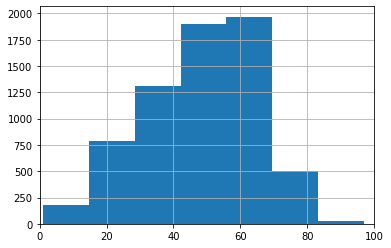

In [7]:
xray_class.df["Patient Age"].hist(bins=30).set_xlim(0,100)

# Download our data
- Parallel download from digital ocean
- prepend system path after download

In [0]:
!rm -rf /content/images
if not os.path.exists(LOCAL_IMAGES_LOCATION):
  !mkdir /content/images

  class Downloader(Thread):
    def __init__(self, file_url, save_path):
        Thread.__init__(self)
        self.file_url = file_url
        self.save_path = save_path

    def run(self):
        remaining_download_tries = 15

        while remaining_download_tries > 0:
            try:
                req.urlretrieve(self.file_url, self.save_path)
                time.sleep(0.1)
            except:
                print("error downloading " + self.file_url +
                      " on trial no: " + str(16 - remaining_download_tries))
                remaining_download_tries = remaining_download_tries - 1
                continue
            else:
                break
  # xray_class.df["Image Index"].apply(lambda x: Downloader(x, LOCAL_IMAGES_LOCATION + x.split('/')[-1] ).start() )

  open_threads = [Downloader(x, LOCAL_IMAGES_LOCATION + x.split('/')[-1] ) for x in xray_class.df["Image Index"]]
  started_threads = [thread.start() for thread in open_threads]
  joined_threads = [thread.join() for thread in open_threads]

In [9]:
#  let's now append the full system path
xray_class.df["Image Index"] = xray_class.df["Image Index"].apply(lambda x : LOCAL_IMAGES_LOCATION + x.split('/')[-1])
xray_class.df.head()

,Image Index,labels,View Position,Follow-up #,Patient ID,Patient Age,Patient Gender,image_width,image_width.1,x_pixel_spacing,y_pixel_spacing
78169,/content/images/00021996_011.png,No Finding,AP,11.0,21996.0,68.0,M,3056.0,2544.0,0.139000,0.139000
54376,/content/images/00014465_018.png,No Finding,AP,18.0,14465.0,65.0,M,2500.0,2048.0,0.168000,0.168000
75104,/content/images/00020912_006.png,No Finding,AP,6.0,20912.0,43.0,M,3056.0,2544.0,0.139000,0.139000
90665,/content/images/00027734_000.png,No Finding,PA,0.0,27734.0,30.0,F,2021.0,2021.0,0.194311,0.194311
9127,/content/images/00001075_030.png,No Finding,AP,30.0,1075.0,59.0,F,3056.0,2544.0,0.139000,0.139000


# Pre-processing of images and label
- split dataframe accordingly with equal numbers of labels in test and train
- batches image
- show image

In [10]:
# Split them into training and validation using NUM_IMAGES 
train_df, valid_df, test_df = xray_class.get_test_train_split_data(len(xray_class.df))

print(train_df.labels.value_counts())
print("="*50)
print(valid_df.labels.value_counts())
print("="*50)
print(test_df.labels.value_counts())


Pleural_Thickening    2708
No Finding            2708
Name: labels, dtype: int64
No Finding            544
Pleural_Thickening    539
Name: labels, dtype: int64
Pleural_Thickening    138
No Finding            133
Name: labels, dtype: int64


In [11]:
# Create training and validation data batches using ImageDataGenerator
train_data = xray_class.generate_image(train_df, True)
val_data   = xray_class.generate_image(valid_df)
test_data   = xray_class.generate_image(test_df)

Found 5416 validated image filenames belonging to 2 classes.
Found 1083 validated image filenames belonging to 2 classes.
Found 271 validated image filenames belonging to 2 classes.


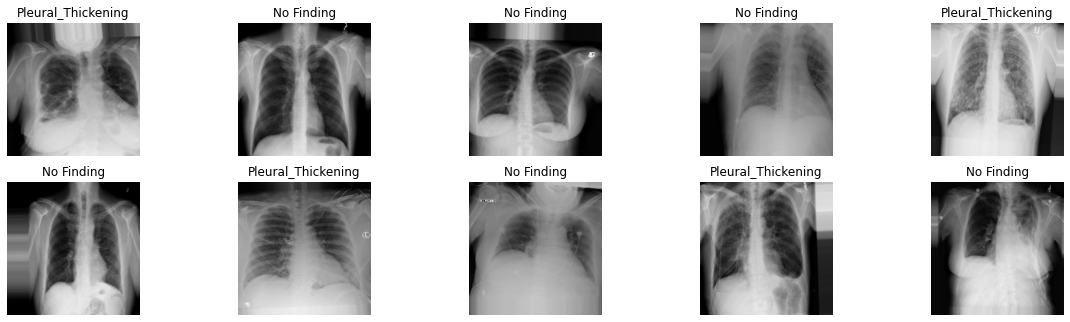

In [12]:
train_images, train_labels = next(train_data)
xray_class.show_25_images(train_images, train_labels)

# Perform model trainining
- fit our data using Categorical classification with metrics of accuracy and optimization Adam
- validate data
- save our model

In [0]:
result = xray_class.cross_validation(EPOCH, train_data, val_data, test_data)

In [24]:
pprint.pprint(result[max(result, key=float)])

model = result[max(result, key=float)]["model"]
a, b = model.evaluate(test_data)

filename= f"{SICKNESS}_{b:.2f}"
xray_class.save_model(model, filename)

{'activation': 'elu',
 'layer': [[256, 0.5]],
 'lr': 0.0005,
 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f487fe96198>,
 'stopping': 8}
  ...
    to  
  ['...']


  ...
    to  
  ['...']


9/9 [==============================] - 4s 462ms/step - loss: 0.5896 - accuracy: 0.7306
Saving model to: /content/xray_code/python_code/models/Pleural_Thickening_0.73.h5...


In [0]:

if not model:
  if xray_class.model_exist(SICKNESS):
      model = xray_class.model_exist(SICKNESS)
      a, b = model.evaluate(test_data)
  else:
      model, stop = xray_class.train_model(EPOCH, train_data, val_data)
      a, b = model.evaluate(test_data)

      filename= f"{SICKNESS}_{b:.2f}"
      xray_class.save_model(model, filename)

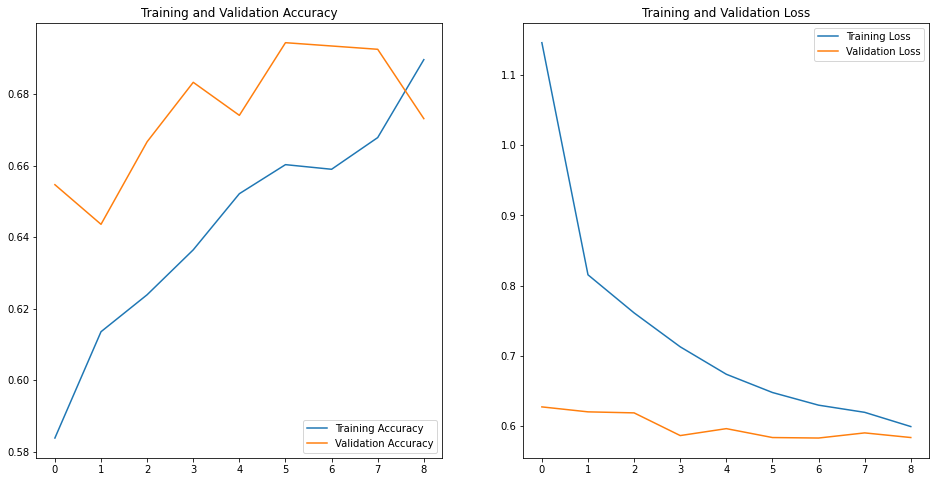

In [25]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs_range = range(stop.stopped_epoch + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Post processing
- Predict our validation data
- load tensorboard
- Show images and percentage of accuracy for those prediction

In [26]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(test_data, verbose=1)

9/9 [==============================] - 6s 681ms/step


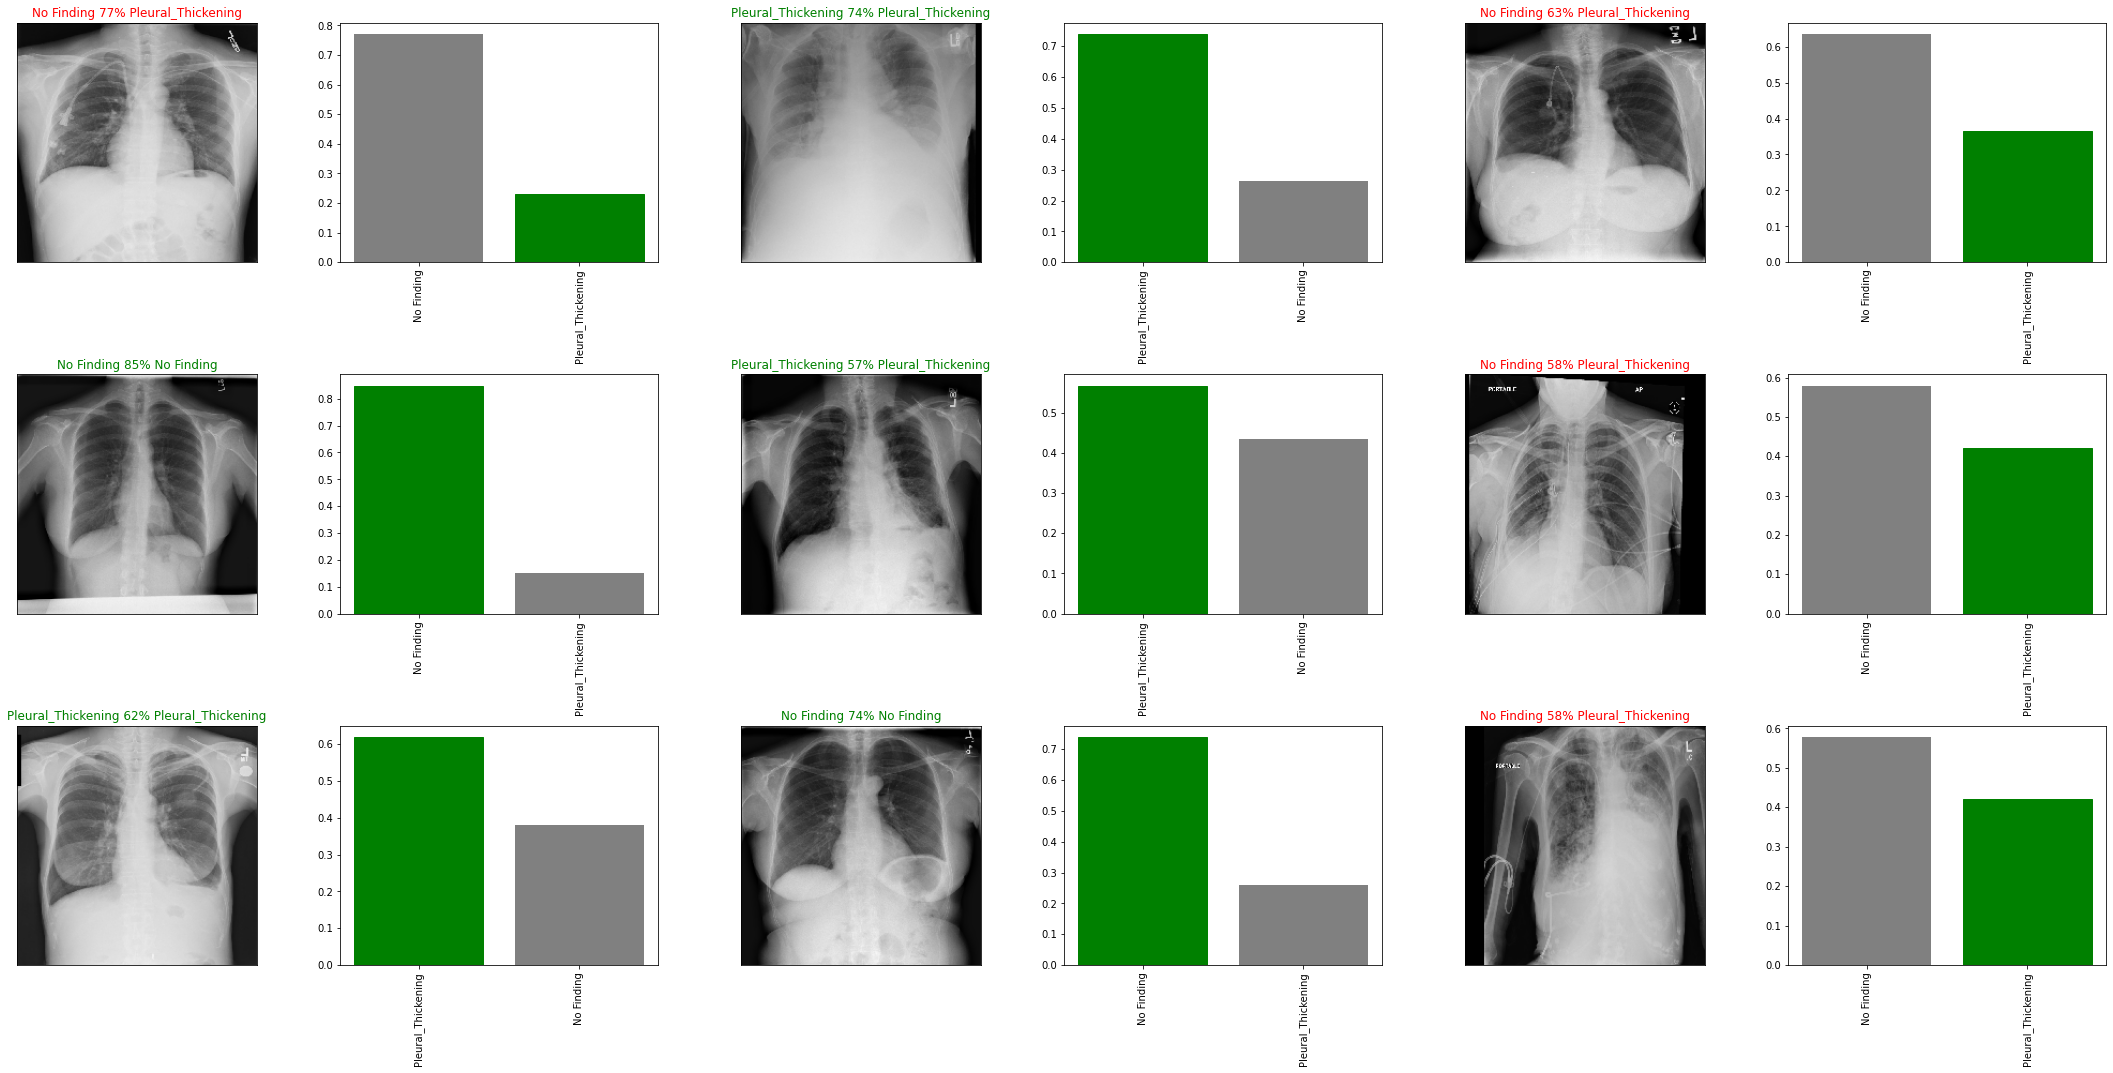

In [27]:
# Let's check a few predictions and their different values
test_images, test_labels = next(test_data)

i_multiplier = 0
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  xray_class.plot_pred(prediction_probabilities=predictions,
            labels=test_labels,
            images=test_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  xray_class.plot_pred_conf(prediction_probabilities=predictions,
                labels=test_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# Evaluating our model
- confusion matrix
- classification report
- loss and accuracy

In [28]:
print(f"Loss : {a}, Accuracy: {b}")

Loss : 0.5896351072523329, Accuracy: 0.7306272983551025


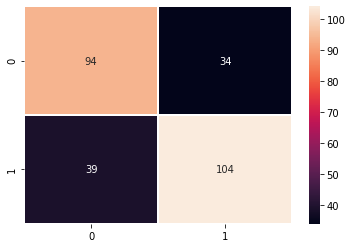

In [29]:
# y_test = [xray_class.get_label(x) for x in predictions] # convert [0,25, 0.75] -> "No Finding/Effusion"
# y_val = [xray_class.get_unique_labels()[x] for x in test_data.labels]
y_test = [test_df.labels.unique()[np.argmax(x)] for x in predictions] # convert [0,25, 0.75] -> "No Finding/Effusion"
y_val = [test_df.labels.unique()[x] for x in test_data.labels]

xray_class.generate_confusion_matrix(y_test, y_val)

In [30]:
xray_class.generate_classification_report(y_test, y_val)

                    precision    recall  f1-score   support

        No Finding       0.71      0.73      0.72       128
Pleural_Thickening       0.75      0.73      0.74       143

          accuracy                           0.73       271
         macro avg       0.73      0.73      0.73       271
      weighted avg       0.73      0.73      0.73       271

